In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,Add,BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,SeparableConv2D,ReLU,GlobalAvgPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.metrics import Recall, Precision

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import seaborn as sns
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from preprocess_blur import preprocess
from Gradcam import GradCAM
from display_random_image import display_image
from display_bar_chart import display_bar_chart

In [2]:
image_size = 300

labels = ['Level_0','Level_1','Level_2','level_3','Level_4']

In [3]:
def create_data(paths):
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):
            image_read = cv.imread(os.path.join(dir,image))
            image_read = cv.cvtColor(image_read,cv.COLOR_BGR2RGB)
            image_resized = preprocess(image_read,sigmaX=10,IMG_SIZE=300)
            image_resized = cv.resize(image_resized,(image_size,image_size))
            image_resized= preprocess_input(image_resized)
            images.append([image_resized,class_num])
            
    return np.array(images)

In [4]:
val = create_data('D:/Kaggle datasets/Thesis_Diabetic/Diabetic_Retinopathy/Val/')

In [5]:
train = create_data('D:/Kaggle datasets/Thesis_Diabetic/Diabetic_Retinopathy/Merged/')

In [6]:
#load train images and labels in X_train and y_train

X_train = []
y_train = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = np.expand_dims(y_train, axis=1)

print(X_train.shape)
print(y_train.shape)

(31209, 300, 300, 3)
(31209, 1)


In [7]:
X_val = []
y_val = []

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)
    
X_val = np.array(X_val)
y_val = np.array(y_val)
y_val = np.expand_dims(y_val, axis=1)

print(X_val.shape)
print(y_val.shape)

(5125, 300, 300, 3)
(5125, 1)


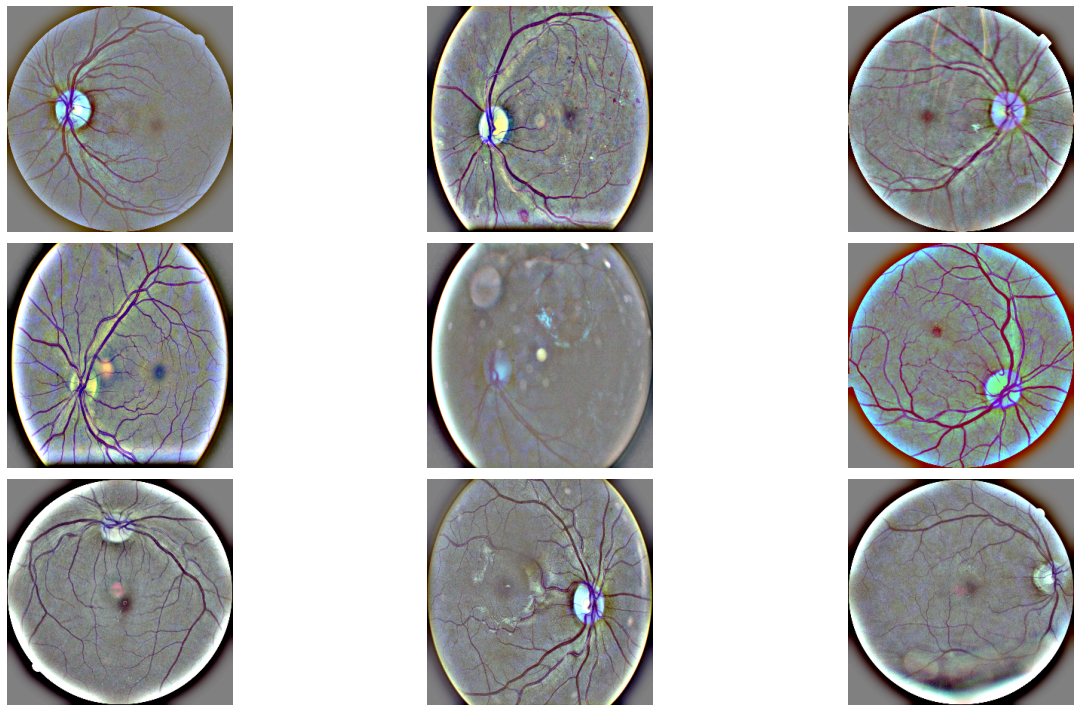

In [8]:
display_image(X_train)

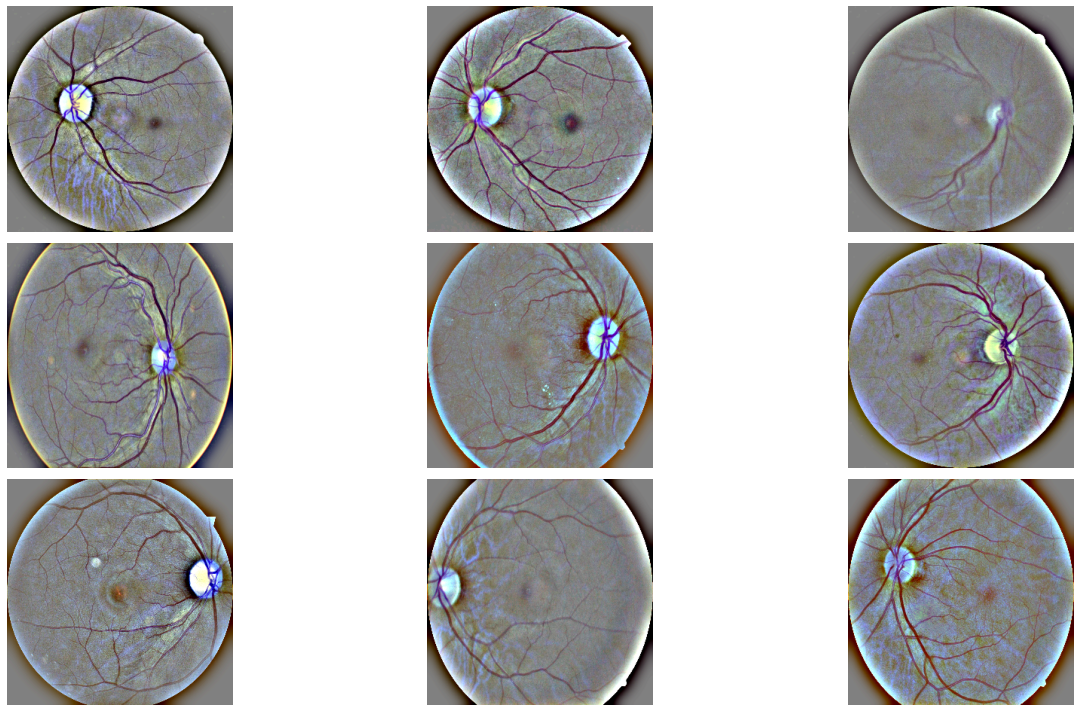

In [9]:
display_image(X_val)

Number of Level_0 images =  6685
Number of Level_1 images =  6180
Number of Level_2 images =  6552
Number of Level_3 images =  5912
Number of Level_4 images =  5880


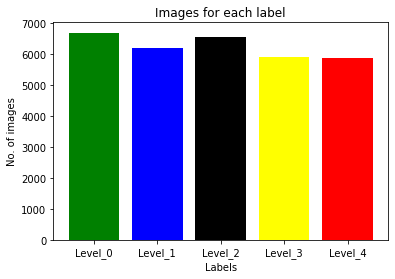

In [10]:
display_bar_chart(y_train)

In [11]:
input_shape = [300,300]

base_model = EfficientNetB3 (input_shape = input_shape+[3], weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.2)(x)
    
outputs = Dense(5, activation="softmax")(x)

# Compile
model = Model(base_model.input, outputs, name="EfficientNet")
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

43941888/43941136 [==============================] - 25s 1us/step


In [12]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [13]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

stopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = ModelCheckpoint('EfficientNetb3_blur_1.h5', monitor='val_loss', save_best_only=True, mode = 'auto')

In [14]:
batch_size = 16

r = model.fit(X_train,y_train, validation_data=(X_val,y_val), 
                        batch_size=batch_size, epochs= 150, 
                        callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/150
1951/1951 [==============================] - 683s 350ms/step - loss: 1.5993 - accuracy: 0.5011 - val_loss: 1.1583 - val_accuracy: 0.6868
Epoch 2/150
1951/1951 [==============================] - 684s 351ms/step - loss: 1.0834 - accuracy: 0.5890 - val_loss: 0.7453 - val_accuracy: 0.7951
Epoch 3/150
1951/1951 [==============================] - 685s 351ms/step - loss: 0.9910 - accuracy: 0.6273 - val_loss: 0.7306 - val_accuracy: 0.8098
Epoch 4/150
1951/1951 [==============================] - 683s 350ms/step - loss: 0.9321 - accuracy: 0.6512 - val_loss: 0.9251 - val_accuracy: 0.7034
Epoch 5/150
1951/1951 [==============================] - 725s 371ms/step - loss: 0.8732 - accuracy: 0.6778 - val_loss: 0.9080 - val_accuracy: 0.7387
Epoch 6/150
1951/1951 [==============================] - 770s 395ms/step - loss: 0.8191 - accuracy: 0.6966 - val_loss: 0.8485 - val_accuracy: 0.7551
Epoch 7/150
1951/1951 [==============================] - 738s 378ms/step - loss: 0.7747 - accuracy: 0.7160

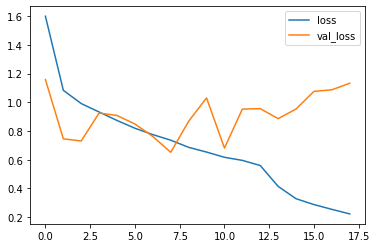

In [15]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

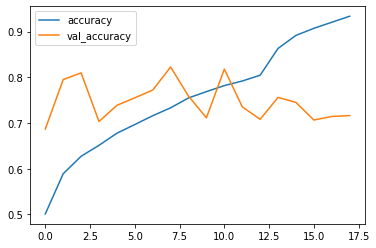

In [16]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [18]:
model2 = tf.keras.models.load_model('EfficientNetb3_blur_1.h5')

In [19]:
P= model2.predict(X_val, steps=len(X_val)).argmax(axis=1)

([<matplotlib.axis.YTick at 0x28a0800b8c8>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

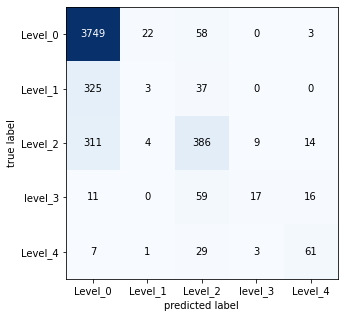

In [20]:
matrix = confusion_matrix (y_val, P)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

In [21]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)

stopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = ModelCheckpoint('EfficientNetb3_blur_2.h5', monitor='val_loss', save_best_only=True, mode = 'auto')

In [22]:
model2.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [23]:
model2.compile(optimizer=Adam(lr=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

batch_size = 4

r = model2.fit(X_train,y_train, validation_data=(X_val,y_val), 
                        batch_size=batch_size, epochs= 50, 
                        callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/50
7803/7803 [==============================] - 935s 120ms/step - loss: 0.6841 - accuracy: 0.7502 - val_loss: 0.8475 - val_accuracy: 0.7579
Epoch 2/50
7803/7803 [==============================] - 893s 114ms/step - loss: 0.5579 - accuracy: 0.8002 - val_loss: 0.9349 - val_accuracy: 0.7454
Epoch 3/50
7803/7803 [==============================] - 928s 119ms/step - loss: 0.4914 - accuracy: 0.8252 - val_loss: 0.7910 - val_accuracy: 0.7725
Epoch 4/50
7803/7803 [==============================] - 957s 123ms/step - loss: 0.4372 - accuracy: 0.8479 - val_loss: 0.8190 - val_accuracy: 0.7772
Epoch 5/50
7803/7803 [==============================] - 951s 122ms/step - loss: 0.3867 - accuracy: 0.8663 - val_loss: 1.0082 - val_accuracy: 0.7208
Epoch 6/50
7803/7803 [==============================] - 898s 115ms/step - loss: 0.3555 - accuracy: 0.8804 - val_loss: 1.0687 - val_accuracy: 0.7153
Epoch 7/50
7803/7803 [==============================] - 884s 113ms/step - loss: 0.3223 - accuracy: 0.8949 - val_

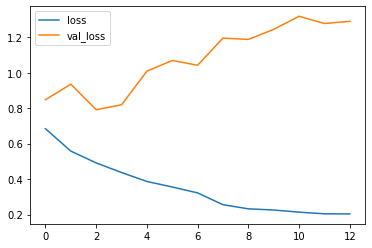

In [24]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

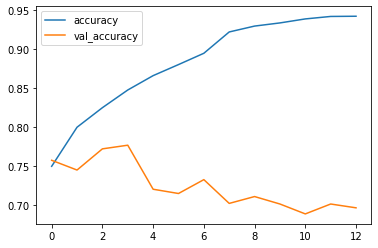

In [25]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [26]:
final_model = tf.keras.models.load_model('EfficientNetb3_blur_2.h5')

In [27]:
P2 = final_model.predict(X_val, batch_size=4).argmax(axis=1)

([<matplotlib.axis.YTick at 0x28a52e640c8>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

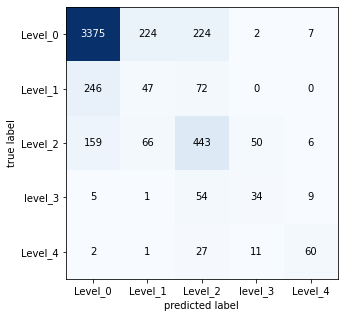

In [28]:
matrix = confusion_matrix (y_val, P2)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def f_score(y,P,level):
    
    print(f'Level_{level}')
    print('Weighted Precision: {:.2f}'.format(precision_score(y, P, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y, P, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y, P, average='weighted')))

In [30]:
def f_score_macro(y,P,level):
    
    print(f'Level_{level}')
    print('Macro Precision: {:.2f}'.format(precision_score(y, P, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y, P, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y, P, average='macro')))

In [31]:
def accuracy (y,P,level):
    
    print(f'Level_{level}')
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y, P)))

In [32]:
f_score(y_val==0,P2==0, 0)

Level_0
Weighted Precision: 0.83
Weighted Recall: 0.83
Weighted F1-score: 0.83


In [33]:
f_score(y_val==1,P2==1, 1)

Level_1
Weighted Precision: 0.88
Weighted Recall: 0.88
Weighted F1-score: 0.88


In [34]:
f_score(y_val==2,P2==2, 2)

Level_2
Weighted Precision: 0.88
Weighted Recall: 0.87
Weighted F1-score: 0.87


In [35]:
f_score(y_val==3,P2==3, 3)

Level_3
Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97


In [36]:
f_score(y_val==4,P2==4, 4)

Level_4
Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99


In [37]:
f_score(y_val,P2, 1234)

Level_1234
Weighted Precision: 0.77
Weighted Recall: 0.77
Weighted F1-score: 0.77


In [38]:
test = create_data('D:/Kaggle datasets/Thesis_Diabetic/Diabetic_Retinopathy/Test/')

In [39]:
#load test images and labels in X_test and y_test

X_test = []
y_test = []

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = np.expand_dims(y_test, axis=1)

print(X_test.shape)
print(y_test.shape)

(53576, 300, 300, 3)
(53576, 1)


### Model_2 results and confusion matrix

Number of Level_0 images =  39533
Number of Level_1 images =  3762
Number of Level_2 images =  7861
Number of Level_3 images =  1214
Number of Level_4 images =  1206


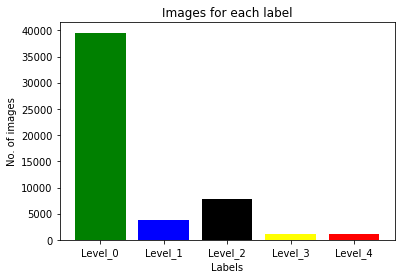

In [40]:
display_bar_chart(y_test)

In [41]:
P3 = final_model.predict(X_test, batch_size=4).argmax(axis=1)

Number of Level_0 images =  39359
Number of Level_1 images =  3377
Number of Level_2 images =  8724
Number of Level_3 images =  1141
Number of Level_4 images =  975


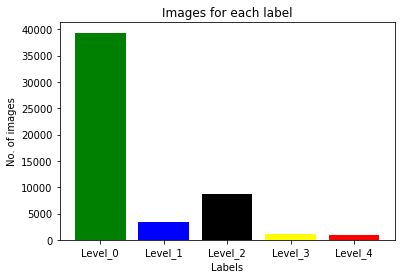

In [42]:
display_bar_chart(P3)

([<matplotlib.axis.YTick at 0x2911a1686c8>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

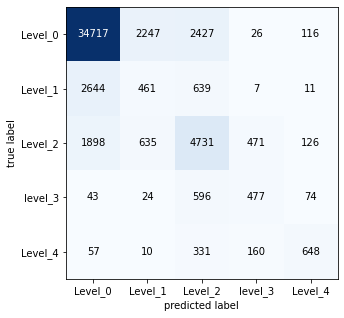

In [43]:
matrix = confusion_matrix (y_test, P3)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

### F_score Weighted Model_2

In [44]:
f_score(y_test==0,P3==0, 0)

Level_0
Weighted Precision: 0.82
Weighted Recall: 0.82
Weighted F1-score: 0.82


In [45]:
f_score(y_test==1,P3==1, 1)

Level_1
Weighted Precision: 0.88
Weighted Recall: 0.88
Weighted F1-score: 0.88


In [46]:
f_score(y_test==2,P3==2, 2)

Level_2
Weighted Precision: 0.87
Weighted Recall: 0.87
Weighted F1-score: 0.87


In [47]:
f_score(y_test==3,P3==3, 3)

Level_3
Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97


In [48]:
f_score(y_test==4,P3==4, 4)

Level_4
Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98


In [49]:
f_score(y_test,P3, 1234)

Level_1234
Weighted Precision: 0.76
Weighted Recall: 0.77
Weighted F1-score: 0.76


### F_score Macro Model_2

In [50]:
f_score_macro(y_test==0,P3==0, 0)

Level_0
Macro Precision: 0.77
Macro Recall: 0.77
Macro F1-score: 0.77



In [51]:
f_score_macro(y_test==1,P3==1, 1)

Level_1
Macro Precision: 0.54
Macro Recall: 0.53
Macro F1-score: 0.53



In [52]:
f_score_macro(y_test==2,P3==2, 2)

Level_2
Macro Precision: 0.74
Macro Recall: 0.76
Macro F1-score: 0.75



In [53]:
f_score_macro(y_test==3,P3==3, 3)

Level_3
Macro Precision: 0.70
Macro Recall: 0.69
Macro F1-score: 0.70



In [54]:
f_score_macro(y_test==4,P3==4, 4)

Level_4
Macro Precision: 0.83
Macro Recall: 0.77
Macro F1-score: 0.79



In [55]:
f_score_macro(y_test,P3, 1234)

Level_1234
Macro Precision: 0.53
Macro Recall: 0.51
Macro F1-score: 0.52



### Accuracy_Model_2

In [56]:
accuracy(y_test==0,P3==0,0)

Level_0

Accuracy: 0.82



In [57]:
accuracy(y_test==1,P3==1,1)

Level_1

Accuracy: 0.88



In [58]:
accuracy(y_test==2,P3==2,2)

Level_2

Accuracy: 0.87



In [59]:
accuracy(y_test==3,P3==3,3)

Level_3

Accuracy: 0.97



In [60]:
accuracy(y_test==4,P3==4,4)

Level_4

Accuracy: 0.98



In [61]:
accuracy(y_test,P3,1234)

Level_1234

Accuracy: 0.77



### Model_1

In [62]:
P4 = model2.predict(X_test, batch_size=4).argmax(axis=1)

Number of Level_0 images =  39533
Number of Level_1 images =  3762
Number of Level_2 images =  7861
Number of Level_3 images =  1214
Number of Level_4 images =  1206


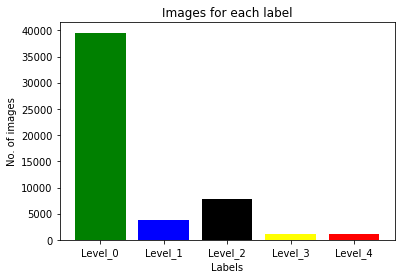

In [63]:
display_bar_chart(y_test)

Number of Level_0 images =  33028
Number of Level_1 images =  8919
Number of Level_2 images =  9480
Number of Level_3 images =  1236
Number of Level_4 images =  913


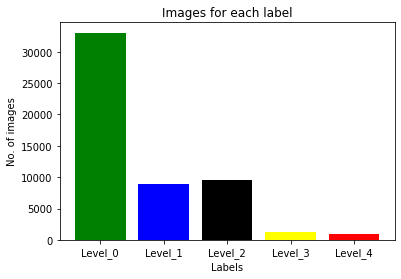

In [64]:
display_bar_chart(P4)

### Accuracy Model_1

In [65]:
accuracy(y_test==0,P4==0,0)
accuracy(y_test==1,P4==1,1)
accuracy(y_test==2,P4==2,2)
accuracy(y_test==3,P4==3,3)
accuracy(y_test==4,P4==4,4)
accuracy(y_test,P4,1234)

Level_0

Accuracy: 0.75

Level_1

Accuracy: 0.80

Level_2

Accuracy: 0.86

Level_3

Accuracy: 0.97

Level_4

Accuracy: 0.98

Level_1234

Accuracy: 0.68



### F_score Model_1

In [66]:
f_score_macro(y_test==0,P4==0,0)
f_score_macro(y_test==1,P4==1,1)
f_score_macro(y_test==2,P4==2,2)
f_score_macro(y_test==3,P4==3,3)
f_score_macro(y_test==4,P4==4,4)
f_score_macro(y_test,P4,1234)

Level_0
Macro Precision: 0.71
Macro Recall: 0.76
Macro F1-score: 0.72

Level_1
Macro Precision: 0.52
Macro Recall: 0.55
Macro F1-score: 0.52

Level_2
Macro Precision: 0.72
Macro Recall: 0.75
Macro F1-score: 0.73

Level_3
Macro Precision: 0.69
Macro Recall: 0.69
Macro F1-score: 0.69

Level_4
Macro Precision: 0.83
Macro Recall: 0.75
Macro F1-score: 0.78

Level_1234
Macro Precision: 0.51
Macro Recall: 0.50
Macro F1-score: 0.50



### F_score Weighted Model_1

In [67]:
f_score(y_test==0,P4==0,0)
f_score(y_test==1,P4==1,1)
f_score(y_test==2,P4==2,2)
f_score(y_test==3,P4==3,3)
f_score(y_test==4,P4==4,4)
f_score(y_test,P4,1234)

Level_0
Weighted Precision: 0.80
Weighted Recall: 0.75
Weighted F1-score: 0.77
Level_1
Weighted Precision: 0.88
Weighted Recall: 0.80
Weighted F1-score: 0.84
Level_2
Weighted Precision: 0.87
Weighted Recall: 0.86
Weighted F1-score: 0.86
Level_3
Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97
Level_4
Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98
Level_1234
Weighted Precision: 0.77
Weighted Recall: 0.68
Weighted F1-score: 0.72


### Confusion_Matrix Model_1

([<matplotlib.axis.YTick at 0x2911a1f2f08>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

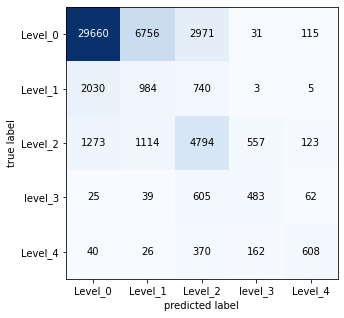

In [68]:
matrix = confusion_matrix (y_test, P4)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

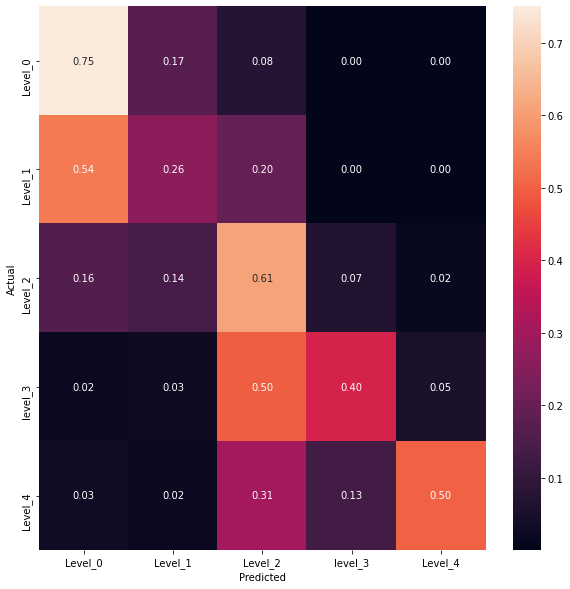

In [69]:
import seaborn as sns

target_names = ['Level_0','Level_1','Level_2','level_3','Level_4']
cm = confusion_matrix(y_test, P4)
# Normalise
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

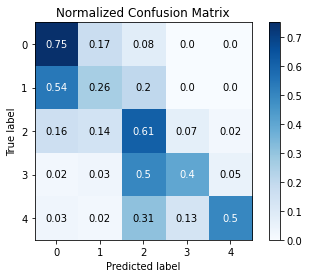

In [70]:
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(y_test, P4, normalize=True)